In [1]:
import os
import numpy as np
import cv2  # Import OpenCV for resizing
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

import gc

physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


2024-11-30 16:46:58.407710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732967218.420139   93504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732967218.423896   93504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 16:46:58.436773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Clear Keras session
tf.keras.backend.clear_session()
# Force garbage collection to release memory
gc.collect()

0

In [2]:
def preprocess_audio_dataset(input_folder, target_sr=16000, target_length=80000, n_mels=40, n_fft=1024, hop_length=512, top_db=20):
    spectrograms = []
    labels = []

    # Iterate over each audio file in the input folder
    for filename in os.listdir(input_folder):

        if filename.endswith((".wav", ".mp3", ".webm")):

            file_path = os.path.join(input_folder, filename)
            # print(f"Processing {filename}")

            # Step 1: Load and resample audio
            y, sr = librosa.load(file_path, sr=target_sr)

            # Step 2: Trim or pad the audio to the target length (5 seconds)
            y = trim_or_pad_audio(y, target_length)

            # Step 3: Remove silence from the audio
            y = remove_silence(y, sr, top_db)

            # Step 4: Generate a log mel-spectrogram
            log_mel_spec = generate_mel_spectrogram(y, sr, n_mels, n_fft, hop_length)

            # Step 5: Resize the spectrogram to 432x288 pixels
            log_mel_spec_resized = resize_spectrogram(log_mel_spec)

            # Store the spectrogram and corresponding label 
            spectrograms.append(log_mel_spec_resized)
            labels.append(filename)
            
        # break
    return spectrograms, labels

def trim_or_pad_audio(y, target_length=80000):
    if len(y) > target_length:
        return y[:target_length]  # Trim to the target length
    else:
        return np.pad(y, (0, target_length - len(y)), 'constant')  # Pad with zeros

def remove_silence(y, sr, top_db=20):
    return librosa.effects.trim(y, top_db=top_db)[0]

def generate_mel_spectrogram(y, sr, n_mels=40, n_fft=1024, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=n_mels, 
        n_fft=n_fft, 
        hop_length=hop_length,
        fmin=20, 
        fmax=8000
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec

def resize_spectrogram(spec, target_size=(224, 224)): # (224, 224)
    # Resize the spectrogram to the desired size using OpenCV
    return cv2.resize(spec, target_size, interpolation=cv2.INTER_LINEAR)

def display_spectrogram(spectrogram, title='Spectrogram'):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram, sr=16000, x_axis='time', y_axis='mel', fmin=20, fmax=8000, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Normalize function based on ImageNet stats (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
    
def preprocess_spectrogram(spectrogram):
    # Convert spectrogram from shape (224, 224) to (224, 224, 3)
    
    # First, normalize the spectrogram if necessary (e.g., if pixel range is [0, 255])
    spectrogram = spectrogram.astype(np.float16) / 255.0
    
    # Replicate the spectrogram into 3 channels (to match ResNet50's expected input shape)
    spectrogram = np.repeat(spectrogram[..., np.newaxis], 3, axis=-1) # Adds 3rd dimension  3
   
    spectrogram = (spectrogram - mean) / std
    
    return spectrogram

In [4]:
# Preprocess the dataset from train folder

# train_folder = 'data/actual/train'
# test_folder = 'data/actual/test'

train_folder = 'data/first_two/train'
test_folder = 'data/first_two/test'

# train_folder = 'data/last_two/train'
# test_folder = 'data/last_two/test'

language_1 = 'punjabi' 
train_path_1 = os.path.join(train_folder, language_1)
#test_path_1 = os.path.join(test_folder, language_1)

language_2 = 'pushto' 
train_path_2 = os.path.join(train_folder, language_2)
#test_path_2 = os.path.join(test_folder, language_2)

language_3 = 'saraiki' 
train_path_3 = os.path.join(train_folder, language_3)
#test_path_3 = os.path.join(test_folder, language_3)

language_4 = 'sindhi' 
train_path_4 = os.path.join(train_folder, language_4)
#test_path_4 = os.path.join(test_folder, language_4)

language_5 = 'urdu'  
train_path_5 = os.path.join(train_folder, language_5)
#test_path_5 = os.path.join(test_folder, language_5)

# Preprocess the train dataset for the language
punjabi_spectrograms, punjabi_labels = preprocess_audio_dataset(train_path_1)
pushto_spectrograms, pushto_labels = preprocess_audio_dataset(train_path_2)
saraiki_spectrograms, saraiki_labels = preprocess_audio_dataset(train_path_3)
sindhi_spectrograms, sindhi_labels = preprocess_audio_dataset(train_path_4)
urdu_spectrograms, urdu_labels = preprocess_audio_dataset(train_path_5)

train_spectrograms = punjabi_spectrograms + sindhi_spectrograms + pushto_spectrograms + saraiki_spectrograms + urdu_spectrograms

train_labels = ['punjabi'] * len(punjabi_spectrograms) + \
         ['sindhi'] * len(sindhi_spectrograms) + \
         ['pushto'] * len(pushto_spectrograms) + \
         ['saraiki'] * len(saraiki_spectrograms) + \
         ['urdu'] * len(urdu_spectrograms)

assert len(train_spectrograms) == len(train_labels), "Mismatch between spectrograms and labels count."

print("Total Spectrograms: ", len(train_spectrograms))

# Display one spectrogram as a sample
# display_spectrogram(train_spectrograms[0], title="train Spectrogram")

Total Spectrograms:  10000


In [5]:
#del punjabi_spectrograms,sindhi_spectrograms,pushto_spectrograms,saraiki_spectrograms,urdu_spectrograms

del saraiki_labels,urdu_labels,punjabi_labels,sindhi_labels,pushto_labels
del sindhi_spectrograms,punjabi_spectrograms,pushto_spectrograms,urdu_spectrograms,saraiki_spectrograms
del train_folder,test_folder 
del train_path_1,train_path_2,train_path_3,train_path_4,train_path_5

gc.collect()

0

In [ ]:
train_spectrograms = np.array([preprocess_spectrogram(s) for s in train_spectrograms])

# Ensure spectrograms are the correct shape
print(f"Train Spectrograms Shape: {train_spectrograms.shape}")
#print(f"Test Spectrograms Shape: {test_spectrograms.shape}")

Train Spectrograms Shape: (10000, 224, 224, 3)


In [7]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)  # Fit and transform the training labels

# Print label mapping for reference
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

train_spectrograms_, val_spectrograms, train_labels_encoded, val_labels_encoded = train_test_split(
    train_spectrograms, train_labels_encoded, test_size=0.2, random_state=42
)

# 1. Create TensorFlow Dataset objects for train and test datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_spectrograms_, train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_spectrograms, val_labels_encoded))


# Shuffle and batch the train dataset
train_dataset = train_dataset.shuffle(len(train_spectrograms_)).batch(16)

# Batch the validation and test datasets (no shuffle needed)
val_dataset = val_dataset.batch(16)

# 4. Inspect the dataset (first batch example)
for images, labels in train_dataset.take(1):  # Just take 1 batch to inspect
    print("Batch image shape:", images.shape)
    print("Batch labels shape:", labels.shape)

# Now you can feed these datasets to your model during training
# Example:
# model.fit(train_dataset, validation_data=test_dataset, epochs=10)


Label Mapping: {np.str_('punjabi'): np.int64(0), np.str_('pushto'): np.int64(1), np.str_('saraiki'): np.int64(2), np.str_('sindhi'): np.int64(3), np.str_('urdu'): np.int64(4)}


I0000 00:00:1732965255.913850   89152 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22979 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-11-30 16:14:15.914616: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9633792000 exceeds 10% of free system memory.
2024-11-30 16:14:19.912717: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9633792000 exceeds 10% of free system memory.
2024-11-30 16:14:23.475998: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.
2024-11-30 16:14:24.490562: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.
2024-11-30 16:14:25.326275: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9633792000 exceeds 10% of free system memory.


Batch image shape: (16, 224, 224, 3)
Batch labels shape: (16,)


2024-11-30 16:14:27.949135: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
del train_spectrograms_,train_labels_encoded,val_spectrograms,val_labels_encoded

In [9]:
del train_spectrograms

In [3]:
    
class BatchLossLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.batch_losses = []
        
    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the CNN model
def create_alex_model(input_shape, num_classes):
  
    model = models.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 1)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2048, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Input shape of spectrograms (224, 224, 3)
input_shape = (224, 224, 3)
num_classes = 5  # 5 languages

# Create the CNN model
model = create_alex_model(input_shape, num_classes)

# Summary of the model
model.summary()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Stop after 2 epochs without improvement
    restore_best_weights=True
    )

batch_logger1 = BatchLossLogger()

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

checkpoint = ModelCheckpoint(
filepath='best_alexmodel_pt1.keras',  # Save file path
monitor='val_loss',       # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
save_best_only=True,      # Save only the model with the best performance
mode='min',               # Mode for monitoring ('min' for loss, 'max' for accuracy)
verbose=1                 # Verbosity level (1 to print saving logs)
)
# Train the model
# Train the model
history1=model.fit(
train_dataset,  # Replace with the 4th folder's training dataset
validation_data=val_dataset,  # Replace with the 4th folder's validation dataset
epochs=20,  # Reduced maximum number of epochs
callbacks=[lr_schedule,early_stopping,checkpoint,batch_logger1
],
verbose=2
)
# Save the model
model.save('best_alexmodel_pt1.keras')

# Evaluate the model
#test_loss, test_accuracy = model.evaluate(test_dataset)
#print(f"Test Accuracy: {test_accuracy:.2f}")

/home/mi08440/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 96)   │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 112, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │   411,043,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,298,437 (1.54 GB)

 Trainable params: 413,297,861 (1.54 GB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/20


I0000 00:00:1732965273.944956   89543 service.cc:148] XLA service 0x7a1bdc0186b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732965273.945091   89543 service.cc:156]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2024-11-30 16:14:34.009390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732965274.276043   89543 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-30 16:14:34.641612: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":


Epoch 1: val_loss improved from inf to 1.99647, saving model to best_alexmodel_pt1.keras
500/500 - 66s - 131ms/step - accuracy: 0.4074 - loss: 4.9449 - val_accuracy: 0.3015 - val_loss: 1.9965 - learning_rate: 1.0000e-03
Epoch 2/20

Epoch 2: val_loss did not improve from 1.99647
500/500 - 37s - 73ms/step - accuracy: 0.4225 - loss: 1.4040 - val_accuracy: 0.3300 - val_loss: 2.5056 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: val_loss did not improve from 1.99647
500/500 - 37s - 73ms/step - accuracy: 0.4055 - loss: 1.3276 - val_accuracy: 0.2290 - val_loss: 2.0209 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: val_loss improved from 1.99647 to 1.84987, saving model to best_alexmodel_pt1.keras
500/500 - 47s - 95ms/step - accuracy: 0.4151 - loss: 1.2426 - val_accuracy: 0.2375 - val_loss: 1.8499 - learning_rate: 1.0000e-03
Epoch 5/20

Epoch 5: val_loss did not improve from 1.84987
500/500 - 37s - 73ms/step - accuracy: 0.4151 - loss: 1.4549 - val_accuracy: 0.1975 - val_loss: 11518.1553 -

In [11]:

del early_stopping,checkpoint,images,input_shape,labels,num_classes

In [4]:
# Preprocess the dataset from train folder
# train_folder = 'data/actual/train'
# test_folder = 'data/actual/test'

train_folder_2 = 'data/last_two/train'
test_folder_2 = 'data/last_two/test'

# train_folder = 'data/last_two/train'
# test_folder = 'data/last_two/test'


language_1 = 'punjabi' 
language_2 = 'pushto' 
language_3 = 'saraiki' 
language_4 = 'sindhi' 
language_5 = 'urdu' 

# Example for one language folder, say 'english' in the train folder
# language_1_2 = 'punjabi' 
train_path_12 = os.path.join(train_folder_2, language_1)
#test_path_1 = os.path.join(test_folder, language_1)

#language_2 = 'pushto' 
train_path_22 = os.path.join(train_folder_2, language_2)
#test_path_2 = os.path.join(test_folder, language_2)

#language_3 = 'saraiki' 
train_path_32 = os.path.join(train_folder_2, language_3)
#test_path_3 = os.path.join(test_folder, language_3)

#language_4 = 'sindhi' 
train_path_42 = os.path.join(train_folder_2, language_4)
#test_path_4 = os.path.join(test_folder, language_4)

#language_5 = 'urdu'  
train_path_52 = os.path.join(train_folder_2, language_5)
#test_path_5 = os.path.join(test_folder, language_5)


# Preprocess the train dataset for the language
punjabi_spectrograms_2, punjabi_labels = preprocess_audio_dataset(train_path_12)
pushto_spectrograms_2, pushto_labels = preprocess_audio_dataset(train_path_22)
saraiki_spectrograms_2, saraiki_labels = preprocess_audio_dataset(train_path_32)
sindhi_spectrograms_2, sindhi_labels = preprocess_audio_dataset(train_path_42)
urdu_spectrograms_2, urdu_labels = preprocess_audio_dataset(train_path_52)

train_spectrograms_2 = punjabi_spectrograms_2 + sindhi_spectrograms_2 + pushto_spectrograms_2 + saraiki_spectrograms_2 + urdu_spectrograms_2

train_labels_2 = ['punjabi'] * len(punjabi_spectrograms_2) + \
         ['sindhi'] * len(sindhi_spectrograms_2) + \
         ['pushto'] * len(pushto_spectrograms_2) + \
         ['saraiki'] * len(saraiki_spectrograms_2) + \
         ['urdu'] * len(urdu_spectrograms_2)

assert len(train_spectrograms_2) == len(train_labels_2), "Mismatch between spectrograms and labels count."

print("Total Spectrograms: ", len(train_spectrograms_2))
train_spectrograms_2 = np.array([preprocess_spectrogram(s) for s in train_spectrograms_2])
#test_spectrograms = np.array([preprocess_spectrogram(s) for s in test_spectrograms])

# Ensure spectrograms are the correct shape
print(f"Train Spectrograms Shape: {train_spectrograms_2.shape}")
# Display one spectrogram as a sample
# display_spectrogram(train_spectrograms[0], title="train Spectrogram")

Total Spectrograms:  10000
Train Spectrograms Shape: (10000, 224, 224, 3)


In [5]:
#del punjabi_spectrograms,sindhi_spectrograms,pushto_spectrograms,saraiki_spectrograms,urdu_spectrograms
del saraiki_labels,urdu_labels,punjabi_labels,sindhi_labels,pushto_labels
del sindhi_spectrograms_2,punjabi_spectrograms_2,pushto_spectrograms_2,urdu_spectrograms_2,saraiki_spectrograms_2
del train_folder_2,test_folder_2 
del train_path_12,train_path_22,train_path_32,train_path_42,train_path_52

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded_2 = label_encoder.fit_transform(train_labels_2)  # Fit and transform the training labels

# # Print label mapping for reference
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

train_spectrograms_2_, val_spectrograms_2, train_labels_encoded_2, val_labels_encoded_2 = train_test_split(
    train_spectrograms_2, train_labels_encoded_2, test_size=0.2, random_state=42
)

# 1. Create TensorFlow Dataset objects for train and test datasets
train_dataset_2 = tf.data.Dataset.from_tensor_slices((train_spectrograms_2_, train_labels_encoded_2))
val_dataset_2 = tf.data.Dataset.from_tensor_slices((val_spectrograms_2, val_labels_encoded_2))


# Shuffle and batch the train dataset
train_dataset_2 = train_dataset_2.shuffle(len(train_spectrograms_2_)).batch(16)

# Batch the validation and test datasets (no shuffle needed)
val_dataset_2 = val_dataset_2.batch(16)

# 4. Inspect the dataset (first batch example)
for images, labels in train_dataset_2.take(1):  # Just take 1 batch to inspect
    print("Batch image shape:", images.shape)
    print("Batch labels shape:", labels.shape)

# Now you can feed these datasets to your model during training
# Example:
# model.fit(train_dataset, validation_data=test_dataset, epochs=10)


Label Mapping: {np.str_('punjabi'): np.int64(0), np.str_('pushto'): np.int64(1), np.str_('saraiki'): np.int64(2), np.str_('sindhi'): np.int64(3), np.str_('urdu'): np.int64(4)}


I0000 00:00:1732967342.724675   93504 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22979 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-11-30 16:49:02.725355: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9633792000 exceeds 10% of free system memory.
2024-11-30 16:49:06.767843: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9633792000 exceeds 10% of free system memory.
2024-11-30 16:49:10.357892: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.
2024-11-30 16:49:11.379944: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.
2024-11-30 16:49:12.234876: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9633792000 exceeds 10% of free system memory.


Batch image shape: (16, 224, 224, 3)
Batch labels shape: (16,)


2024-11-30 16:49:14.895005: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
del train_labels_encoded_2,train_spectrograms_2_
del val_labels_encoded_2,val_spectrograms_2
del images,labels

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


#model = load_model('cnn_pt1.keras')
model = load_model('best_alexmodel_pt1.keras')

# Load the model trained on the 3rd folder
lr_schedule_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping_2 = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Stop after 2 epochs without improvement
    restore_best_weights=True
    )


batch_logger_2 = BatchLossLogger()
checkpoint_2 = ModelCheckpoint(
filepath='best_alexmodel_pt2.keras',  # Save file path
monitor='val_loss',       # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
save_best_only=True,      # Save only the model with the best performance
mode='min',               # Mode for monitoring ('min' for loss, 'max' for accuracy)
verbose=1                 # Verbosity level (1 to print saving logs)
)
# Train the model
# Train the model
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history2=model.fit(
train_dataset_2,  # Replace with the 4th folder's training dataset
validation_data=val_dataset_2,  # Replace with the 4th folder's validation dataset
epochs=20,  # Reduced maximum number of epochs
callbacks=[lr_schedule_2,early_stopping_2,checkpoint_2,batch_logger_2
],
verbose=1
)
# Save the model
#model.save('alex_pt2.keras')

# Evaluate the model
#test_loss, test_accuracy = model.evaluate(test_dataset)
#print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/20


I0000 00:00:1732967373.852035   93838 service.cc:148] XLA service 0x788f1c018770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732967373.852054   93838 service.cc:156]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2024-11-30 16:49:33.906000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732967374.175133   93838 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-30 16:49:34.490796: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":

  2/500 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.7656 - loss: 0.6395   

I0000 00:00:1732967382.604895   93838 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7079 - loss: 0.7777

2024-11-30 16:50:19.163102: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
E0000 00:00:1732967419.487966   93838 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732967419.672251   93838 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in N


Epoch 1: val_loss improved from inf to 49194.42969, saving model to best_alexmodel_pt2.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 105ms/step - accuracy: 0.7079 - loss: 0.7778 - val_accuracy: 0.1985 - val_loss: 49194.4297 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5820 - loss: 1.3211
Epoch 2: val_loss improved from 49194.42969 to 6.28176, saving model to best_alexmodel_pt2.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.5822 - loss: 1.3205 - val_accuracy: 0.3120 - val_loss: 6.2818 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7594 - loss: 0.6151
Epoch 3: val_loss did not improve from 6.28176
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.7594 - loss: 0.6151 - val_accuracy: 0.3895 - val_loss: 8.9187 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8151 - loss: 0.4960
Epoch 4: val_loss improved from 6.28176 to 0.80118, saving model to

In [9]:
del train_dataset_2,val_dataset_2,checkpoint_2,early_stopping_2

In [10]:
combined_loss = history1.history['loss'] + history2.history['loss']
combined_val_loss = history1.history['val_loss'] + history2.history['val_loss']
#96 train acc 80 valid acc for best model pt1 : its bestmodelpt2
#97 train acc 71 valid acc cnnpt2



NameError: name 'history1' is not defined

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(combined_loss) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, combined_loss, label='Training Loss')
plt.plot(epochs, combined_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Combine batch losses
combined_batch_losses = batch_logger1.batch_losses + batch_logger_2.batch_losses
steps = list(range(1, len(combined_batch_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(steps, combined_batch_losses, label='Loss Per Step')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs. Steps')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
del batch_logger1,batch_logger_2    
del combined_batch_losses,combined_loss,combined_val_loss
del epochs,history1,history2,language_1,language_2,language_3,language_4,language_5,steps

In [11]:
# Preprocess the dataset from train folder

test_folder = 'data/first_two/test'
test_folder_2 = 'data/last_two/test'

# Example for one language folder, say 'english' in the train folder
language_1 = 'punjabi' 

test_path_1 = os.path.join(test_folder, language_1)
test_path_12 = os.path.join(test_folder_2, language_1)


language_2 = 'pushto' 

test_path_2 = os.path.join(test_folder, language_2)
test_path_22 = os.path.join(test_folder_2, language_2)

language_3 = 'saraiki' 

test_path_3 = os.path.join(test_folder, language_3)
test_path_32 = os.path.join(test_folder_2, language_3)

language_4 = 'sindhi' 

test_path_4 = os.path.join(test_folder, language_4)
test_path_42 = os.path.join(test_folder_2, language_4)

language_5 = 'urdu'  

test_path_5 = os.path.join(test_folder, language_5)
test_path_52 = os.path.join(test_folder_2, language_5)

# Preprocess the test dataset for the language
test_punjabi_spectrograms, test_punjabi_labels = preprocess_audio_dataset(test_path_1)
test_pushto_spectrograms, test_pushto_labels = preprocess_audio_dataset(test_path_2)
test_saraiki_spectrograms, test_saraiki_labels = preprocess_audio_dataset(test_path_3)
test_sindhi_spectrograms, test_sindhi_labels = preprocess_audio_dataset(test_path_4)
test_urdu_spectrograms, test_urdu_labels = preprocess_audio_dataset(test_path_5)

test2_punjabi_spectrograms, test2_punjabi_labels = preprocess_audio_dataset(test_path_12)
test2_pushto_spectrograms, test2_pushto_labels = preprocess_audio_dataset(test_path_22)
test2_saraiki_spectrograms, test2_saraiki_labels = preprocess_audio_dataset(test_path_32)
test2_sindhi_spectrograms, test2_sindhi_labels = preprocess_audio_dataset(test_path_42)
test2_urdu_spectrograms, test2_urdu_labels = preprocess_audio_dataset(test_path_52)


test_spectrograms = test_punjabi_spectrograms+ test2_punjabi_spectrograms+ test_sindhi_spectrograms+test2_sindhi_spectrograms + test_pushto_spectrograms +test2_pushto_spectrograms+ test_saraiki_spectrograms+test2_saraiki_spectrograms  + test_urdu_spectrograms+test2_urdu_spectrograms 

test_labels = [0] * len(test_punjabi_spectrograms+test2_punjabi_spectrograms) + \
         [3] * len(test_sindhi_spectrograms+test2_sindhi_spectrograms) + \
         [1] * len(test_pushto_spectrograms+test2_pushto_spectrograms) + \
         [2] * len(test_saraiki_spectrograms+test2_saraiki_spectrograms ) + \
         [4] * len(test_urdu_spectrograms+test2_urdu_spectrograms )
assert len(test_spectrograms) == len(test_labels), "Mismatch between spectrograms and labels count."



print("Total Spectrograms: ", len(test_spectrograms))
print("Total Labels: ", len(test_labels))
test_spectrograms = np.array([preprocess_spectrogram(s) for s in test_spectrograms])

# Ensure spectrograms are the correct shape

print(f"Test Spectrograms Shape: {test_spectrograms.shape}")

Total Spectrograms:  5000
Total Labels:  5000
Test Spectrograms Shape: (5000, 224, 224, 3)


In [12]:
# del language_1,language_2,language_3,language_4,language_5
# del test_folder,test_folder_2
# del test_path_1,test_path_12,test2_urdu_spectrograms,test2_punjabi_labels,test2_pushto_labels
del test_path_2,test_path_22,test_path_3,test_path_32,test_path_4,test_path_42,test_path_5,test_path_52
del test_punjabi_labels,test_punjabi_spectrograms,test_pushto_labels,test_pushto_spectrograms,test_saraiki_labels,test_saraiki_spectrograms
del test_sindhi_labels,test_sindhi_spectrograms,test_urdu_labels,test_urdu_spectrograms
del test2_punjabi_spectrograms,test2_pushto_spectrograms,test2_saraiki_labels,test2_saraiki_spectrograms,test2_sindhi_labels
del test2_sindhi_spectrograms,test2_urdu_labels




2024-11-30 17:09:49.738437: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
E0000 00:00:1732968590.113022   93837 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732968590.297157   93837 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in N

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

2024-11-30 17:10:03.975848: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
E0000 00:00:1732968604.331200   93838 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732968604.514784   93838 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsi

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Overall Accuracy: 0.7756


2024-11-30 17:10:06.743806: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


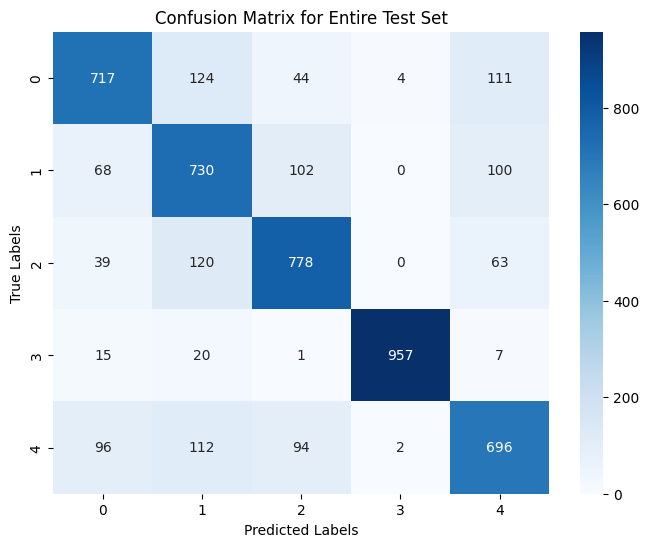

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.72      0.74      1000
     Class 1       0.66      0.73      0.69      1000
     Class 2       0.76      0.78      0.77      1000
     Class 3       0.99      0.96      0.98      1000
     Class 4       0.71      0.70      0.70      1000

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_entire_testset(model, test_spectrograms, test_labels, labels_class):
    """
    Evaluates the model on the entire test set and computes the accuracy, confusion matrix,
    and a classification report.

    Args:
        model: The trained model to evaluate.
        test_spectrograms: Array of test spectrograms.
        test_labels: Array of corresponding test labels.
        labels_class: List of all possible class labels (e.g., [0, 1, 2, 3, 4]).

    Returns:
        overall_accuracy: The accuracy of the model on the test set.
        cm: The confusion matrix for the test set.
    """
    # Convert test data into a TensorFlow Dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((test_spectrograms, test_labels))
    test_dataset = test_dataset.batch(32)  # Batch size

    # Predictions and true labels
    predictions = []
    true_labels = []

    for images, labels in test_dataset:
        # Predict the labels
        preds = model.predict(images)
        predicted_labels = np.argmax(preds, axis=1)  # Get the predicted class
        predictions.extend(predicted_labels)
        true_labels.extend(labels.numpy())  # Convert true labels to numpy array

    # Compute overall accuracy
    overall_accuracy = accuracy_score(true_labels, predictions)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=labels_class)

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_class, yticklabels=labels_class)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Entire Test Set')
    plt.show()

    # Print the classification report
    report = classification_report(true_labels, predictions, target_names=[f'Class {label}' for label in labels_class])
    print("Classification Report:")
    print(report)

    return overall_accuracy, cm


# Example usage
from tensorflow.keras.models import load_model
model = load_model('best_alexmodel_pt2.keras')  # Load your model

# Assuming `test_spectrograms` and `test_labels` are already defined
labels_class = [0, 1, 2, 3, 4]  # All possible classes
overall_accuracy, cm = evaluate_entire_testset(model, test_spectrograms, test_labels, labels_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

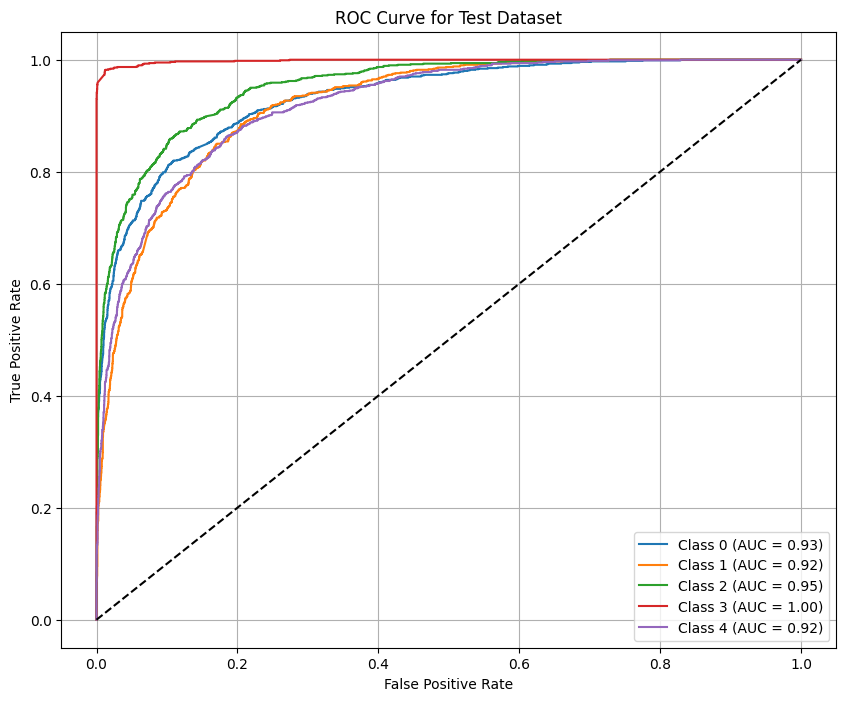

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming test_dataset is your tf.data.Dataset, and the model is already trained
test_dataset = tf.data.Dataset.from_tensor_slices((test_spectrograms, test_labels))
test_dataset = test_dataset.batch(16)  
# Initialize lists to store the true labels and predicted probabilities
true_labels = []
pred_probs = []

# Iterate over the test dataset
for spectrograms, labels in test_dataset:
    # Predict probabilities for the batch
    batch_pred_probs = model.predict(spectrograms)
    
    # Store the true labels and predicted probabilities
    true_labels.append(labels.numpy())  # Convert Tensor to numpy array
    pred_probs.append(batch_pred_probs)

# Convert lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_probs = np.concatenate(pred_probs, axis=0)

# Binarize the true labels for ROC
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
n_classes = true_labels_bin.shape[1]

# Plot ROC curve
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [15]:
del true_labels,true_labels_bin,tpr,spectrograms,roc_auc,pred_probs,overall_accuracy,n_classes,model,labels_class,labels,label_encoder,i,fpr,cm,batch_pred_probs